(bread-price-comparison)=
# Bread Price Comparison
---

![udana.jpg](img/udana.jpg)

$^{1}$Image credit: https://www.zumarragakoazoka.eus/es/

## Background
As elsewhere, bread prices also increased in Spain during 2022. That made me wonder which bread types where cheaper among the ones I can buy around. That is, considering the price per weight unit.

Basically three different types of bread are sold in my town:

- In the twice-a-week street market, a bunch of local bakers sell home-made artisan-type loaves.
- In the bakery, breads baked every night in their local bakery are sold.
- In stores (supermarkets, convenience stores), you can find baguettes which are baked on site using pre-made dough that comes frozen from a factory.

I had the impression that `market` breads were more expensive and `store` breads were cheaper, with `bakery` breads in the middle. But I did not really know, that was just an impression coming from the different approaches: more artisan vs more industrial.

So I decided to conduct a little study.

## The data
During a few months I collected data from the bread units I bought —all of them white-wheat breads. Whenever I came back home with my loaf or baguette, I weighed it on my scale and wrote down the grams and the price in euros. I gave each a nickname after its name (if it had one) or the seller's, adding some other distintive information in the designation. In most cases I bought the same bread more than once to get mean values in this study, as breads never weigh exactly the same.

## Import packages

In [1]:
# Basic packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn package
from sklearn.cluster import KMeans

## Import data

In [2]:
# From my .csv file
breads_df = pd.read_csv("data/breads.csv")
breads_df

,name,weight,eur,type
0,Ilargi_350b,340,1.50,bakery
1,Ilargi_250b,278,1.40,bakery
2,Ilargi_Bikoitz_300,260,1.40,bakery
3,Labekoa_350b,357,1.50,bakery
4,Ilargi_Baserri,600,2.55,bakery
...,...,...,...,...
80,Eroski_Rustica,399,1.59,store
81,Udana_900l,855,2.50,market
82,Udana_700l,670,1.90,market
83,Ilargi_Baserri,593,2.30,bakery


I count the number of entries to see how data is distributed by type.

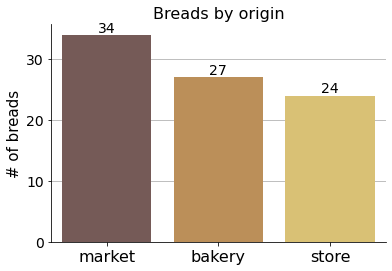

In [3]:
hue_order = ["market", "bakery", "store"]
# sns.set_palette("bright")
palette = ["#7A5652", "#CB9049", "#E9CA65"]

fig, ax = plt.subplots(figsize=(6, 4))

sns.countplot(x="type", data=breads_df, ax=ax,
              order=hue_order,
              palette=palette,
             )

ax.grid(axis="y")
ax.set_axisbelow(True)
ax.tick_params(axis='x', labelsize=16, rotation=0)
ax.tick_params(axis='y', labelsize=14)
ax.set_title("Breads by origin", size=16)
ax.set_xlabel("")
ax.set_ylabel("# of breads", size=15)
ax.bar_label(ax.containers[0], size=14)
sns.despine()

plt.show()

## Best price chart
I calculate the cost of the bread per kilogram and insert it in a new column in the dataframe, then sort values in ascending order.

In [4]:
# Add column with bread price per kg
breads_df["eur/kg"] = 1000 * breads_df["eur"] / breads_df["weight"]

# Sort values by bread weight per euro column
breads_df = breads_df.sort_values("eur/kg")
breads_df.head()

,name,weight,eur,type,eur/kg
67,Eroski_Mediana,243,0.45,store,1.851852
60,Eroski_Mediana,224,0.45,store,2.008929
55,Dia_Molino,244,0.55,store,2.254098
61,Eroski_Baguette,218,0.50,store,2.293578
65,Dia_Molino,232,0.55,store,2.370690


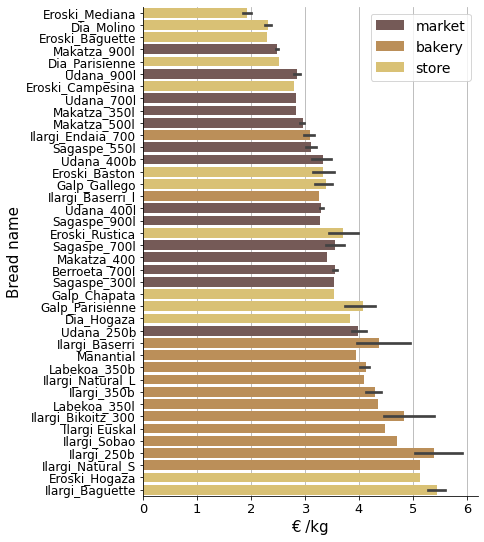

In [5]:
# Plot
fig, ax = plt.subplots(figsize=(6, 9))

sns.barplot(x="eur/kg", y="name", data=breads_df, ax=ax,
            hue="type", hue_order=hue_order, palette=palette,
            dodge=False)

ax.grid(axis="x")
ax.set_axisbelow(True)
ax.tick_params(axis='x', labelsize=13, rotation=0)
ax.tick_params(axis='y', labelsize=12)
ax.set_title("", size=16)
ax.set_xlabel("€ /kg", fontsize=15)
ax.set_ylabel("Bread name", fontsize=15)
ax.legend(fontsize=14)
sns.despine()

plt.show()

This is the chart with bread's mean prices per kilogram. Error bars indicate 95% confidence intervals, so whenever there is an overlapping we cannot conclude a significant difference.

Overall though, market breads were clearly cheaper. Not surpisingly, since they tend to be bigger and have better unit price. We can see that in the next scatter plot.

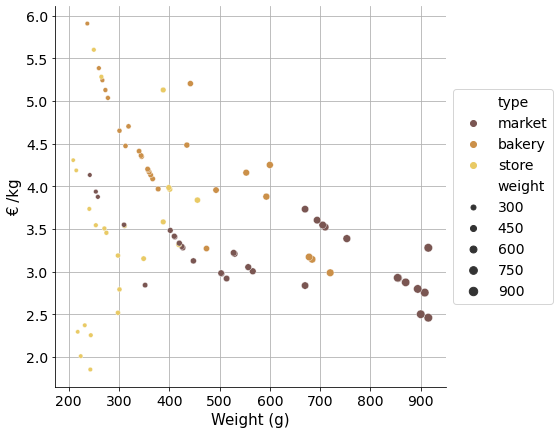

In [6]:
# Plot
fig, ax = plt.subplots(figsize=(7, 7))

sns.scatterplot(x="weight", y="eur/kg", data=breads_df, ax=ax,
                     hue="type", hue_order=hue_order, palette=palette,
                     size="weight")

ax.grid(axis="both")
ax.set_axisbelow(True)
ax.tick_params(axis='x', labelsize=14, rotation=0)
ax.tick_params(axis='y', labelsize=14)
ax.set_title("", size=16)
ax.set_xlabel("Weight (g)", fontsize=15)
ax.set_ylabel("€ /kg", fontsize=15)
ax.legend(bbox_to_anchor=(1.0, 0.5), loc='center left', fontsize=14)
sns.despine()

plt.show()

But to compare prices properly and be able to conclude price differences between `market`, `bakery` and `store` breads, we need to cluster these observations in categorical size groups.

## Cluster sizes
I defined 5 size groups: "XS" (eXtra Small), "S" (Small), "M" (Medium), "L" (Large) and "XL" (eXtra Large). Instead of doing it myself, I used a k-means custering model to find these clusters in the data.

In [7]:
%%capture
# Define the clusters
sizes = ["XS", "S", "M", "L", "XL"]

# Create a KMeans model instance
kmeans = KMeans(n_clusters=len(sizes), random_state=0)

# Sort values by weight
breads_df = breads_df.sort_values("weight")

# Create a sorted 2D array of weights to feed the model
weights = np.array(breads_df["weight"]).reshape(-1, 1)

# Fit model
kmeans.fit(weights)

# Obtained cluster labels
labels = kmeans.labels_
labels

In [8]:
%%capture
# Center points consistent with labels
centers = kmeans.cluster_centers_
centers

In [9]:
%%capture
df = pd.DataFrame(centers).sort_values(0)
df = df.reset_index()
df.columns=["labels", "center"]
df["sizes"] = sizes
df

In [10]:
%%capture
key = {label: size for label, size in zip(df["labels"], df["sizes"])}
key

In [11]:
%%capture
breads_df["label"] = labels
breads_df["size"] = [key[i] for i in breads_df["label"]]
breads_df

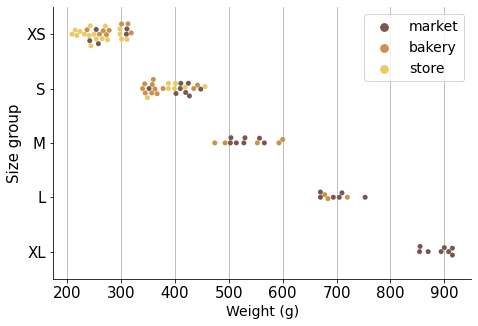

In [12]:
# Plot
fig, ax = plt.subplots(figsize=(7.5, 5))

sns.swarmplot(x="weight", y="size", data=breads_df, ax=ax,
              hue="type", hue_order=hue_order, palette=palette)

ax.grid(axis="x")
ax.set_axisbelow(True)
ax.tick_params(axis='x', labelsize=15, rotation=0)
ax.tick_params(axis='y', labelsize=15)
ax.set_title("", size=16)
ax.set_xlabel("Weight (g)", fontsize=14)
ax.set_ylabel("Size group", fontsize=15)
ax.legend(fontsize=14)
sns.despine()

plt.show()

Now that I have them in similar size groups, the observations are ready for comparison.

## Price comparison

In [13]:
# # Plot
# g = sns.catplot(x="type", y="eur/kg", data=breads_df,
#                 kind="bar", order=hue_order,
#                 hue="type", hue_order=hue_order,
#                 col="size", col_wrap=2,
#                 # height=4, aspect=1.5,
#                 dodge=False
#                )
# 
# g.set_titles(size=16, weight="bold")
# g.set_xticklabels(size=14)
# g.set_yticklabels(size=14)
# g.set_xlabels("", size=14)
# g.set_ylabels("Prize (€/kg)", size=14)
# 
# g.axes[4].annotate("XL size breads sold \nonly in the market",
#                    xy=(1, 2.1), fontsize=14, fontstyle="italic")
# 
# for i in range(5):
#     g.axes[i].grid(axis="y")
#     g.axes[i].set_axisbelow(True)
# 
# plt.show()

The bar plots above show the mean prices per kilogram, per size and type. As there are multiple observations in each category, the Seaborn function uses bootstrapping to compute a confidence interval around the estimate, which is plotted using error bars. Therefore we can do a simple *visual statistical test* to asses whether prices are significantly different. If error bars do not overlap, there is a statistically significant difference in the prices, i.e. we know that the p-value is less than 0.05 just by looking at the picture.

In [14]:
breads_df

,name,weight,eur,type,eur/kg,label,size
47,Galp_Parisienne,209,0.90,store,4.306220,2,XS
53,Galp_Parisienne,215,0.90,store,4.186047,2,XS
61,Eroski_Baguette,218,0.50,store,2.293578,2,XS
60,Eroski_Mediana,224,0.45,store,2.008929,2,XS
65,Dia_Molino,232,0.55,store,2.370690,2,XS
...,...,...,...,...,...,...,...
38,Udana_900l,894,2.50,market,2.796421,1,XL
8,Makatza_900l,900,2.25,market,2.500000,1,XL
7,Udana_900l,908,2.50,market,2.753304,1,XL
52,Makatza_900l,915,2.25,market,2.459016,1,XL


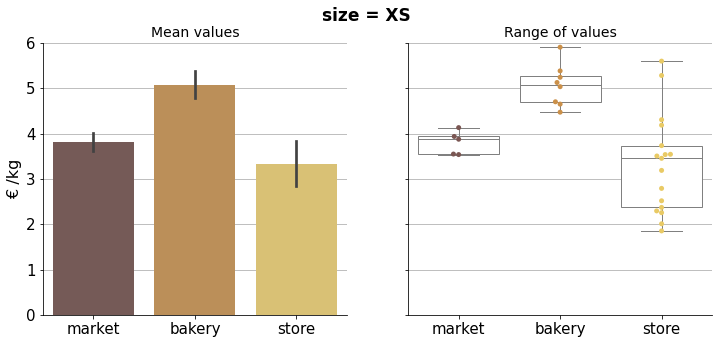

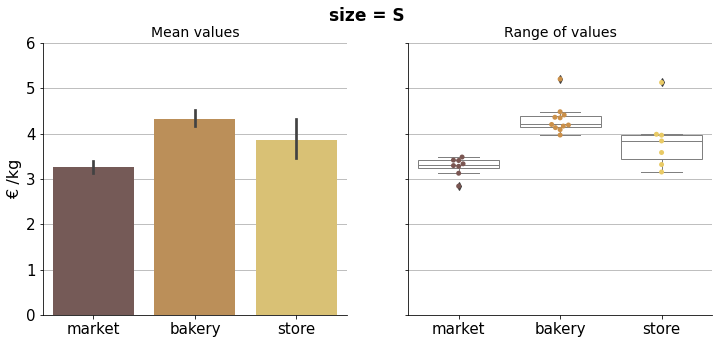

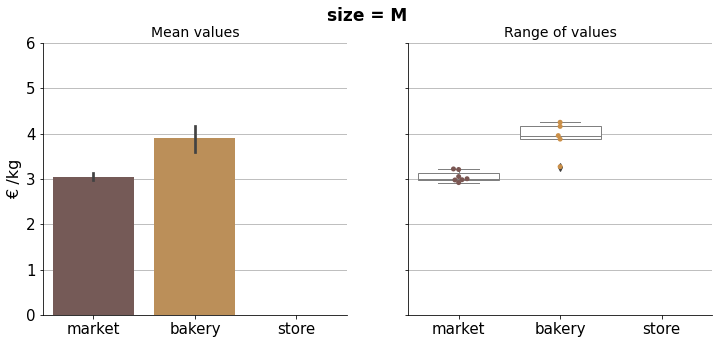

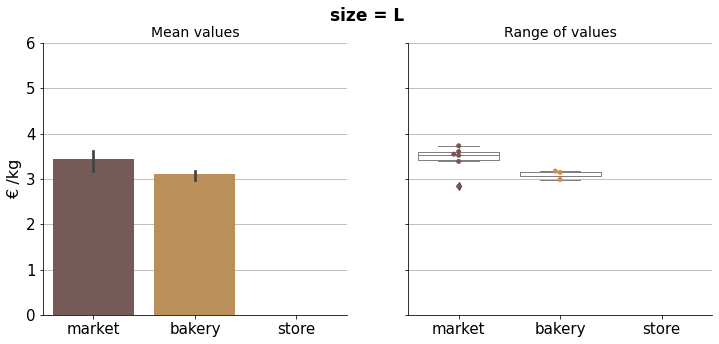

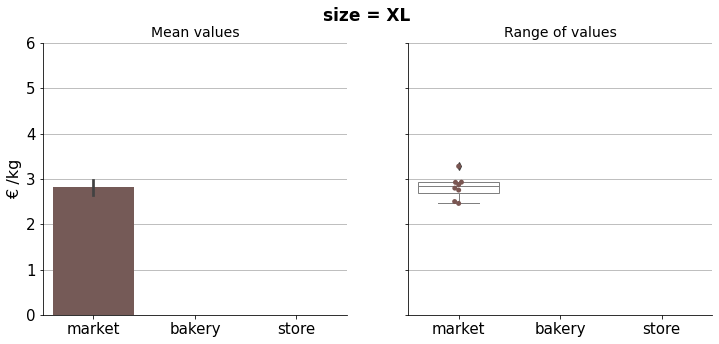

In [15]:
for size in sizes:
    df = breads_df[breads_df["size"] == size]

    fig, ax = plt.subplots(1, 2, sharey=True, figsize=(12, 5))

    fig.suptitle(f'size = {size}', fontsize=17, fontweight="bold")

    sns.despine()

    sns.barplot(x="type", y="eur/kg", data=df, ax=ax[0],
                order=hue_order, palette=palette,
                hue="type", hue_order=hue_order, dodge=False)

    sns.swarmplot(x="type", y="eur/kg", data=df, ax=ax[1],
                order=hue_order, palette=palette,
                hue="type", hue_order=hue_order, dodge=False)
    sns.boxplot(x="type", y="eur/kg", data=df, ax=ax[1],
                order=hue_order, palette=palette,
                hue="type", hue_order=hue_order, dodge=False,
                boxprops=dict(linewidth=1, facecolor='white', edgecolor='grey', alpha=1),
                whiskerprops=dict(linewidth=1, color='grey', alpha=1),
                medianprops=dict(linewidth=1, color="grey", alpha=1),
                capprops=dict(linewidth=1, color='grey', alpha=1),
               )


    for i in range(2):
        ax[i].grid(axis="y")
        ax[i].set_axisbelow(True)
        ax[i].set_xlabel("")
        ax[i].legend().set_visible(False)
        ax[i].tick_params(axis='both', which='major', labelsize=15)

    ax[0].set_ylabel("€ /kg", size=16)
    ax[1].set_ylabel("", size=15)

    ax[0].set_title("Mean values", size=14)
    ax[1].set_title("Range of values", size=14)
    
    ax[0].set_ylim(0, 6)



    plt.show()

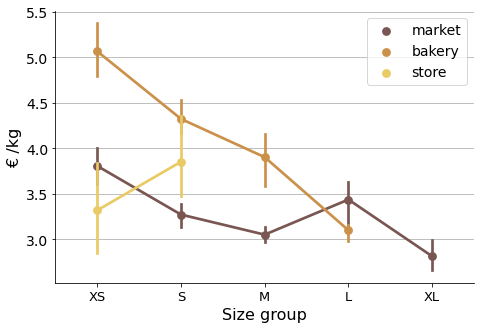

In [17]:
# Plot
fig, ax = plt.subplots(figsize=(7.5, 5))

sns.pointplot(x="size", y="eur/kg", data=breads_df, ax=ax,
                hue="type", hue_order=hue_order, palette=palette,)

ax.grid(axis="y")
ax.set_axisbelow(True)
ax.tick_params(axis='y', which='major', labelsize=14)
ax.tick_params(axis='x', which='major', labelsize=13)
ax.set_title("", size=15)
ax.set_xlabel("Size group", size=16)
ax.set_ylabel("€ /kg", size=16)
ax.legend(fontsize=14)
sns.despine()

plt.show()